In [1]:
import numpy as np
import pandas as pd
import os
from keras.callbacks import EarlyStopping

from qrnn import get_model, qloss
from dataloader import get_data, get_weather, get_hod, get_dow, get_train_set_qrnn, get_test_set_qrnn

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

Using TensorFlow backend.


In [2]:
data_set = 'Irish_2010'
year = '2010'
path = os.path.abspath(os.path.join(os.getcwd(), '../..'))

data = get_data(path, data_set)

100%|██████████| 918/918 [00:29<00:00, 30.61it/s]


In [3]:
month = 1
n_clusters = 2
method = 'hierarchical/euclidean'

path_cluster = os.path.join(path, 'result', data_set, 'clustering', 'point', method, f'n_clusters_{n_clusters}.csv')
clusters = pd.read_csv(path_cluster, header=None)

series = data[:, month-1, :months[month-1]*24]
weather = get_weather(path, data_set, month)
week = get_dow(data_set, month)
day = get_hod(month)

In [4]:
error_train = []
error_test = []

for i in range(1, n_clusters):

    index = list(clusters[month-1] == i)
    sub_series = series[index]
    sub_series = np.sum(sub_series, axis=0)
    
    total_series = np.vstack((sub_series, weather, week, day))
    
    test = total_series[:, -168:]
    train = total_series[:, :-168]
    
    scale = np.zeros(2)
    scale[0] = np.max(train[0])
    scale[1] = np.min(train[0])
    train[0] = (train[0] - scale[1]) / (scale[0] - scale[1])
    test[0] = (test[0] - scale[1]) / (scale[0] - scale[1])
    
    lag = 24
    d = 1

    trainX, trainY = get_train_set_qrnn(train, lag, d)
    testX, testY = get_test_set_qrnn(train, test, lag, d)

    # Parameters
    input_dim = (lag + d) * 2 + 3
    num_hidden_layers = 1
    num_unit = 10
    num_units = [num_unit, num_unit]
    act = ['relu', 'relu']

    # Get model
    model = get_model(input_dim, num_units, act, num_hidden_layers)

    # Train
    hist = model.fit(x=trainX, y=trainY, epochs=300, verbose=0)
    
    pred = model.predict(x=trainX)
    error_train.append(qloss(trainY, pred))

    # Test
    pred = model.predict(x=testX)
    error_test.append(qloss(testY, pred))

    break

In [5]:
# np.save('error_train.npy', np.array(error_train))
# np.save('error_test.npy', np.array(error_test))

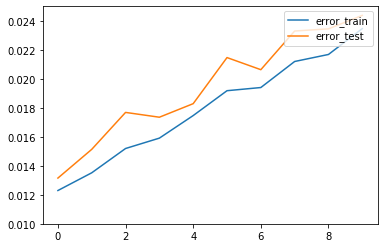

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

# error_train = np.load('error_train.npy')
# error_test = np.load('error_test.npy')

# plt.plot(error_train)
# plt.plot(error_test)
# plt.ylim((0.01, 0.025))
# plt.legend(['error_train', 'error_test'], loc='upper right')